In [20]:
# Import TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Import data handling and preprocessing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

# Import visualization libraries
import matplotlib.pyplot as plt

# Import OS for file path handling
import os


In [ ]:
Non_glucoma_dir = "https://github.com/Bishwaprotapi/Using_Deep_Learning_Model_to_Detect_Glaucoma/tree/main/Non-glucoma"
glucoma_dir = "https://github.com/Bishwaprotapi/Using_Deep_Learning_Model_to_Detect_Glaucoma/tree/main/glucoma"

In [23]:
import shutil 
base_dir = 'data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
raw_non_glaucoma_path = os.path.basename(Non_glucoma_dir)
raw_glaucoma_path = os.path.basename(glucoma_dir)

In [24]:
# Collect image paths and labels
image_paths = []
labels = []

# Process non-glaucoma images
if os.path.exists(raw_non_glaucoma_path):
    print(f"Processing images from: {raw_non_glaucoma_path}")
    for img_name in os.listdir(raw_non_glaucoma_path):
        # Check if it's a file and a common image extension
        if os.path.isfile(os.path.join(raw_non_glaucoma_path, img_name)) and \
           img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            image_paths.append(os.path.join(raw_non_glaucoma_path, img_name))
            labels.append('non-glaucoma')
else:
    print(f"Warning: Directory not found: {raw_non_glaucoma_path}. No non-glaucoma images processed.")

Processing images from: Non-glucoma


In [25]:
# Process glaucoma images
if os.path.exists(raw_glaucoma_path):
    print(f"Processing images from: {raw_glaucoma_path}")
    for img_name in os.listdir(raw_glaucoma_path):
        # Check if it's a file and a common image extension
        if os.path.isfile(os.path.join(raw_glaucoma_path, img_name)) and \
           img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            image_paths.append(os.path.join(raw_glaucoma_path, img_name))
            labels.append('glaucoma')
else:
    print(f"Warning: Directory not found: {raw_glaucoma_path}. No glaucoma images processed.")

Processing images from: glucoma


In [27]:
# Create a DataFrame
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Shuffle the DataFrame
df = shuffle(df, random_state=42).reset_index(drop=True)

print(f"\n--- Raw Data Summary ---")
print(f"Total images found: {len(df)}")
print(f"Class distribution:\n{df['label'].value_counts()}")


--- Raw Data Summary ---
Total images found: 1041
Class distribution:
label
non-glaucoma    757
glaucoma        284
Name: count, dtype: int64


In [28]:
if len(df) == 0:
    print("No images found. Please ensure 'glucoma' and 'Non-glucoma' directories exist and contain images.")
else:

    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42) # 0.5 of 0.3 is 0.15

    print(f"\n--- Dataset Split Summary ---")
    print(f"Train set size: {len(train_df)} (Glaucoma: {train_df['label'].value_counts().get('glaucoma', 0)}, Non-Glaucoma: {train_df['label'].value_counts().get('non-glaucoma', 0)})")
    print(f"Validation set size: {len(val_df)} (Glaucoma: {val_df['label'].value_counts().get('glaucoma', 0)}, Non-Glaucoma: {val_df['label'].value_counts().get('non-glaucoma', 0)})")
    print(f"Test set size: {len(test_df)} (Glaucoma: {test_df['label'].value_counts().get('glaucoma', 0)}, Non-Glaucoma: {test_df['label'].value_counts().get('non-glaucoma', 0)})")



--- Dataset Split Summary ---
Train set size: 728 (Glaucoma: 199, Non-Glaucoma: 529)
Validation set size: 156 (Glaucoma: 42, Non-Glaucoma: 114)
Test set size: 157 (Glaucoma: 43, Non-Glaucoma: 114)


In [29]:
    # Ensure base_dir and its subdirectories are created
    # It's good practice to remove existing data directories to ensure a clean split
    if os.path.exists(base_dir):
        print(f"\nRemoving existing data directory: {base_dir}")
        shutil.rmtree(base_dir)
    
    # Create the directory structure for the splits
    os.makedirs(os.path.join(train_dir, 'glaucoma'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'non-glaucoma'), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, 'glaucoma'), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, 'non-glaucoma'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'glaucoma'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'non-glaucoma'), exist_ok=True)

    # Function to copy images to their respective split directories
    def copy_images_to_split_dirs(dataframe, target_base_dir):
        for index, row in dataframe.iterrows():
            src_path = row['image_path']
            label = row['label']
            dest_dir = os.path.join(target_base_dir, label)
            dest_path = os.path.join(dest_dir, os.path.basename(src_path))
            try:
                shutil.copy(src_path, dest_path)
            except FileNotFoundError:
                print(f"Warning: Source file not found: {src_path}. Skipping.")
            except Exception as e:
                print(f"Error copying {src_path} to {dest_path}: {e}")

    print("\nCopying images to training directories...")
    copy_images_to_split_dirs(train_df, train_dir)
    print("Copying images to validation directories...")
    copy_images_to_split_dirs(val_df, validation_dir)
    print("Copying images to testing directories...")
    copy_images_to_split_dirs(test_df, test_dir)

    print("\nData preparation complete. Directories created and images copied.")



Removing existing data directory: data

Copying images to training directories...
Copying images to validation directories...
Copying images to testing directories...

Data preparation complete. Directories created and images copied.



--- Displaying Sample Images from Training Set ---
Classes found: ['glaucoma', 'non-glaucoma']


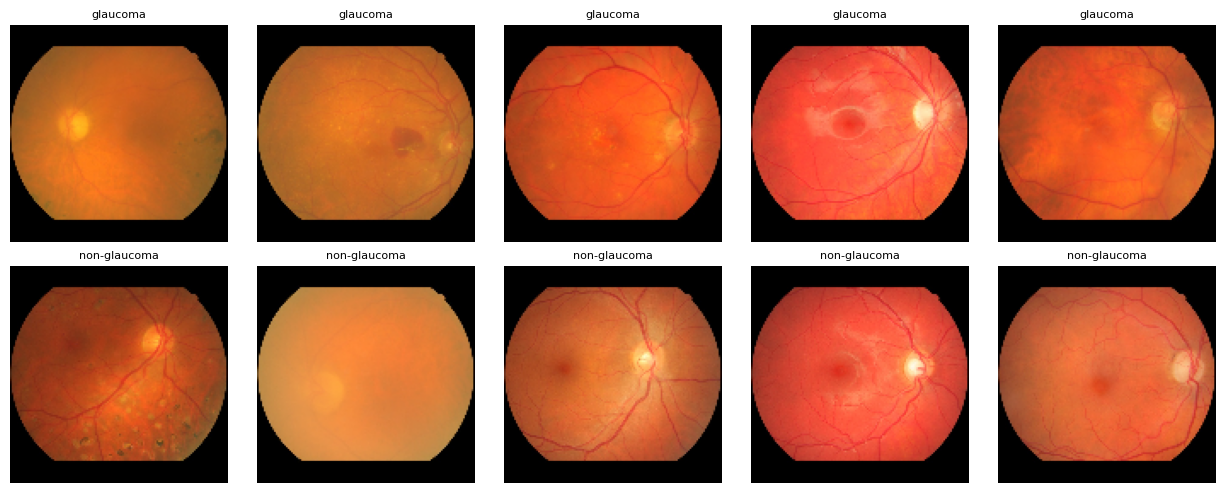

In [30]:
# This code visualizes a sample of images from the training set.
# It assumes 'train_dir' is defined from previous cells.
# It also assumes 'os', 'matplotlib.pyplot' (as plt), 'load_img', 'img_to_array' (from tensorflow.keras.preprocessing.image),
# and 'numpy' (as np) are imported in previous cells or are globally available in the notebook environment.

# Get class names from the train directory
class_names = sorted(os.listdir(train_dir)) # Sort for consistent order
num_classes = len(class_names)
num_images_to_show_per_class = 5 # Number of images to display per class

print(f"\n--- Displaying Sample Images from Training Set ---")
print(f"Classes found: {class_names}")

# Calculate figure size dynamically based on the number of classes and images per class
# Adjust these values (e.g., 2.5) as needed for better visualization
fig_width = num_images_to_show_per_class * 2.5
fig_height = num_classes * 2.5

# Create subplots, ensuring 'axes' is always a 2D array for consistent indexing
fig, axes = plt.subplots(num_classes, num_images_to_show_per_class, figsize=(fig_width, fig_height), squeeze=False)

# Iterate through each class
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    
    # Get all image files in the directory for the current class
    # Filter to ensure only common image file extensions are considered
    all_img_names = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    
    # Select the first 'num_images_to_show_per_class' images
    # If a class has fewer images than requested, it will take all available
    selected_img_names = all_img_names[:num_images_to_show_per_class]

    # Iterate through the selected images for the current class
    for img_idx, img_name in enumerate(selected_img_names):
        img_path = os.path.join(class_path, img_name)

        # Load image and preprocess for display (normalize pixel values)
        try:
            img = load_img(img_path, target_size=(128, 128)) # Load image with target size
            img = img_to_array(img) / 255.0 # Convert to array and normalize pixel values to [0, 1]
        except Exception as e:
            print(f"Warning: Could not load or process image {img_path}: {e}. Displaying placeholder.")
            # Display a black placeholder image if loading fails
            img = np.zeros((128, 128, 3)) # Black image placeholder
            
        # Plot the image on the corresponding subplot
        ax = axes[class_idx, img_idx]
        ax.imshow(img)
        ax.set_title(f"{class_name}", fontsize=8) # Title each image with its class name
        ax.axis('off') # Turn off axis labels and ticks
    
    # If a class has fewer than 'num_images_to_show_per_class' images,
    # turn off the axes for the remaining empty subplots in that row to keep it clean.
    for i in range(len(selected_img_names), num_images_to_show_per_class):
        ax = axes[class_idx, i]
        ax.axis('off')

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the figure


In [33]:
def get_image_counts_per_class(directory):
    image_counts = {}
    # Define common image file extensions
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp')

    if not os.path.isdir(directory):
        print(f"Warning: Directory not found: {directory}")
        return image_counts

    # Iterate through each subdirectory (class) in the main directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count only files with image extensions
            count = sum(1 for file_name in os.listdir(class_path) if file_name.lower().endswith(image_extensions))
            image_counts[class_name] = count
    return image_counts


In [34]:
def get_all_image_paths(directory):

    all_image_paths = {}
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp')

    if not os.path.isdir(directory):
        print(f"Warning: Directory not found: {directory}")
        return all_image_paths

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_images = []
            for file_name in os.listdir(class_path):
                if file_name.lower().endswith(image_extensions):
                    image_path = os.path.join(class_path, file_name)
                    class_images.append(image_path)
            all_image_paths[class_name] = class_images
    return all_image_paths


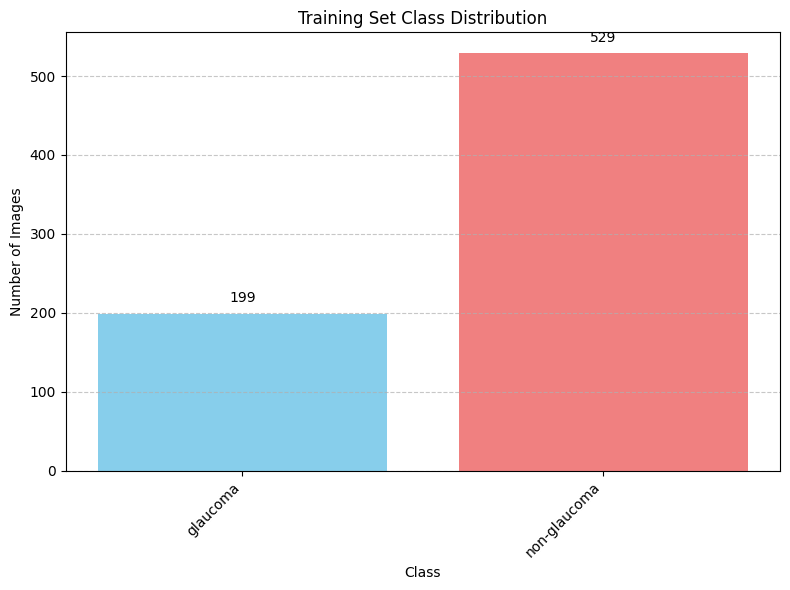

In [35]:
# Class Distribution - Training Set

# Assuming 'train_dir' is defined in a previous cell, e.g., train_dir = 'data/train'

train_class_counts = get_image_counts_per_class(train_dir)

if train_class_counts:
    classes = list(train_class_counts.keys())
    counts = list(train_class_counts.values())

    # Sort classes alphabetically for consistent plotting, or by count if preferred
    # For two classes, alphabetical is usually fine.
    sorted_indices = sorted(range(len(classes)), key=lambda k: classes[k])
    classes = [classes[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]

    plt.figure(figsize=(8, 6))
    # Use distinct colors for the two classes (e.g., 'Normal' and 'Glaucoma')
    colors = ['skyblue', 'lightcoral']
    plt.bar(classes, counts, color=colors[:len(classes)]) # Ensure enough colors for classes
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Training Set Class Distribution')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability if class names are long
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    # Add count labels on top of bars
    for i, count in enumerate(counts):
        plt.text(i, count + (max(counts) * 0.02), str(count), ha='center', va='bottom', fontsize=10)

    plt.show()
else:
    print(f"No image counts found for the training directory: {train_dir}. Please ensure the directory exists and contains image data.")


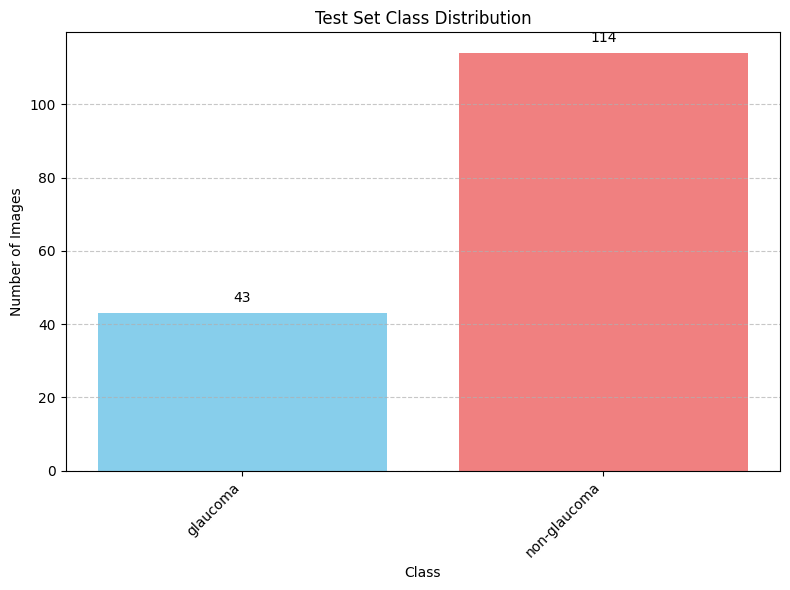

In [36]:
# Class Distribution - Test Set

# Assuming 'test_dir' is defined in a previous cell, e.g., test_dir = 'data/test'

test_class_counts = get_image_counts_per_class(test_dir)

if test_class_counts:
    classes = list(test_class_counts.keys())
    counts = list(test_class_counts.values())

    # Sort classes alphabetically for consistent plotting, or by count if preferred
    # For two classes, alphabetical is usually fine.
    sorted_indices = sorted(range(len(classes)), key=lambda k: classes[k])
    classes = [classes[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]

    plt.figure(figsize=(8, 6))
    # Use distinct colors for the two classes (e.g., 'Normal' and 'Glaucoma')
    colors = ['skyblue', 'lightcoral']
    plt.bar(classes, counts, color=colors[:len(classes)]) # Ensure enough colors for classes
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Test Set Class Distribution')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability if class names are long
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    # Add count labels on top of bars
    for i, count in enumerate(counts):
        plt.text(i, count + (max(counts) * 0.02), str(count), ha='center', va='bottom', fontsize=10)

    plt.show()
else:
    print(f"No image counts found for the test directory: {test_dir}. Please ensure the directory exists and contains image data.")


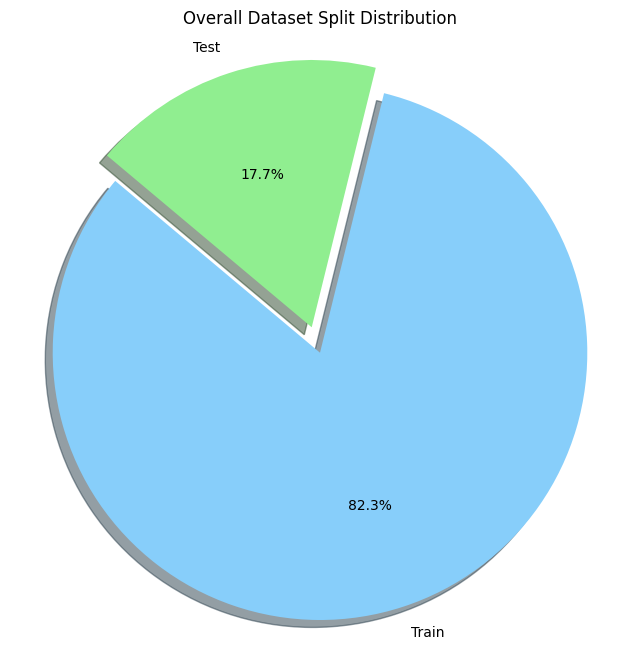

In [40]:
# Overall Dataset Split (Pie Chart)

# Assuming train_class_counts, val_class_counts, and test_class_counts are available from previous cells.
# If val_class_counts is not explicitly calculated, it would be similar to train/test:
# Define val_dir to resolve NameError, assuming a similar structure to train_dir and test_dir
val_dir = 'data/val' # Placeholder: Adjust this path if your validation directory is different
val_class_counts = get_image_counts_per_class(val_dir)

# Calculate total images for each split
total_train_images = sum(train_class_counts.values()) if train_class_counts else 0
total_val_images = sum(val_class_counts.values()) if val_class_counts else 0
total_test_images = sum(test_class_counts.values()) if test_class_counts else 0

# Prepare data for the pie chart
labels = ['Train', 'Validation', 'Test']
sizes = [total_train_images, total_val_images, total_test_images]
colors = ['lightskyblue', 'lightcoral', 'lightgreen'] # Distinct colors for each split
explode = (0.05, 0.05, 0.05) # "explode" a slice if you want to emphasize it

# Filter out splits with zero images to avoid errors in pie chart
filtered_labels = [label for i, label in enumerate(labels) if sizes[i] > 0]
filtered_sizes = [size for size in sizes if size > 0]
filtered_colors = [color for i, color in enumerate(colors) if sizes[i] > 0]
filtered_explode = [exp for i, exp in enumerate(explode) if sizes[i] > 0]

if not filtered_sizes:
    print("No images found in any dataset split to plot the overall distribution.")
else:
    plt.figure(figsize=(8, 8))
    plt.pie(filtered_sizes, explode=filtered_explode, labels=filtered_labels, colors=filtered_colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Overall Dataset Split Distribution')
    plt.show()


--- 1. Sample Images ---

Displaying 5 sample images from 'glaucoma' class (Train Set):


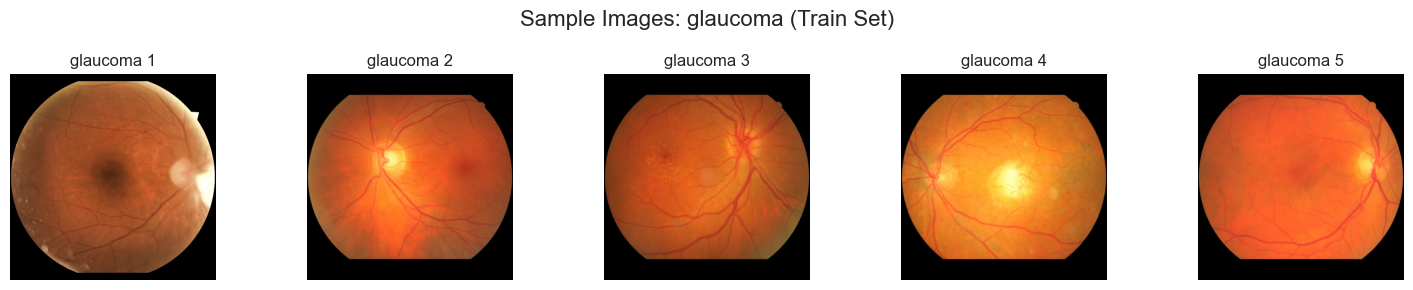


Displaying 5 sample images from 'non-glaucoma' class (Train Set):


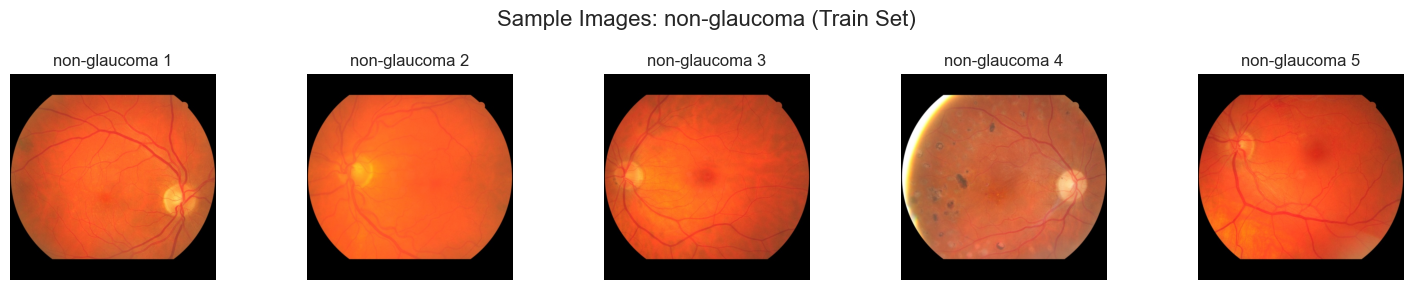

In [60]:
# Determine class names dynamically from available counts
all_classes = sorted(list(set(list(train_class_counts.keys()) + list(val_class_counts.keys()) + list(test_class_counts.keys()))))
if not all_classes:
    print("No classes found in any dataset split. Cannot generate visualizations.")
else:
    # --- 1. Sample Images (10 ) ---
    print("--- 1. Sample Images ---")
    num_samples_per_class = 5

    for class_name in all_classes:
        print(f"\nDisplaying {num_samples_per_class} sample images from '{class_name}' class (Train Set):")
        class_image_paths = get_image_paths(train_dir, class_name)
        if not class_image_paths:
            print(f"No images found for class '{class_name}' in {train_dir}")
            continue

        sample_paths = random.sample(class_image_paths, min(num_samples_per_class, len(class_image_paths)))

        plt.figure(figsize=(15, 3))
        for i, img_path in enumerate(sample_paths):
            plt.subplot(1, num_samples_per_class, i + 1)
            try:
                img = Image.open(img_path)
                plt.imshow(img)
                plt.title(f"{class_name} {i+1}")
                plt.axis('off')
            except Exception as e:
                print(f"Could not load image {img_path}: {e}")
                plt.title("Error")
                plt.axis('off')
        plt.suptitle(f"Sample Images: {class_name} (Train Set)", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


--- Pixel Intensity Distribution for a Sample of 5 Training Images ---


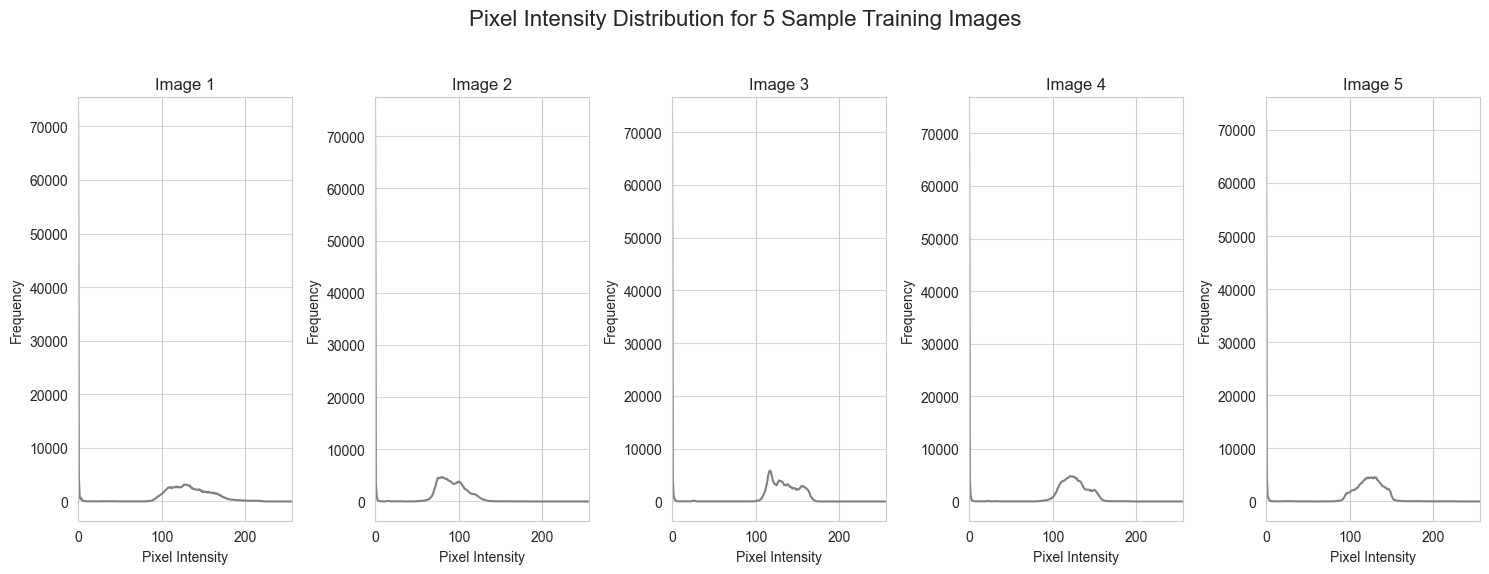

In [62]:
# Get all training image paths across all classes
all_train_image_paths = []
for class_name in all_classes:
    all_train_image_paths.extend(get_image_paths(train_dir, class_name))

if not all_train_image_paths:
    print("No training images found to plot pixel intensity distribution.")
else:
    num_images_for_hist = 5 # Number of images to sample for intensity distribution
    sampled_paths = random.sample(all_train_image_paths, min(num_images_for_hist, len(all_train_image_paths)))

    print(f"\n--- Pixel Intensity Distribution for a Sample of {len(sampled_paths)} Training Images ---")

    plt.figure(figsize=(15, 6)) # Adjust figure size as needed
    for i, img_path in enumerate(sampled_paths):
        plt.subplot(1, len(sampled_paths), i + 1)
        try:
            # Load image and convert to grayscale for intensity distribution
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)

            # Calculate histogram of pixel intensities
            # Bins=256 for 8-bit images (0-255 intensity values)
            hist, bins = np.histogram(img_array.flatten(), bins=256, range=[0, 256])

            plt.plot(hist, color='gray')
            plt.title(f"Image {i+1}")
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")
            plt.xlim([0, 256])
            plt.grid(axis='y', alpha=0.75)
        except Exception as e:
            print(f"Could not process image {img_path} for histogram: {e}")
            plt.title("Error")
            plt.axis('off')

    plt.suptitle(f"Pixel Intensity Distribution for {len(sampled_paths)} Sample Training Images", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



--- Calculating Average Image Brightness per Class ---
Processing 199 images for class: 'glaucoma'
Processing 529 images for class: 'non-glaucoma'


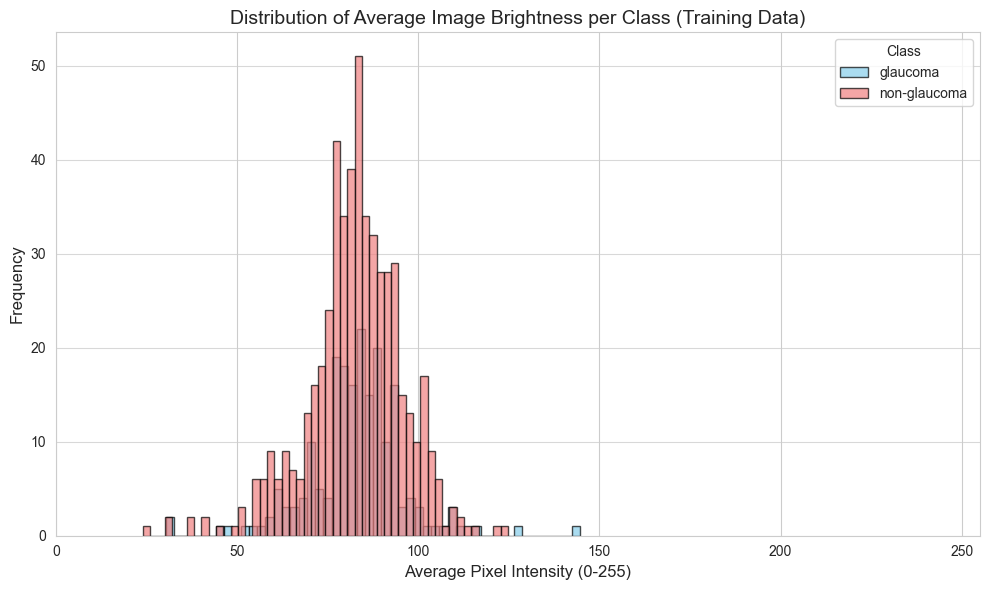

In [63]:
average_brightness_per_class = {}

print("\n--- Calculating Average Image Brightness per Class ---")

for class_name in all_classes:
    class_image_paths = get_image_paths(train_dir, class_name)
    brightness_values = []
    if not class_image_paths:
        print(f"No images found for class: '{class_name}' in training directory. Skipping.")
        average_brightness_per_class[class_name] = [] # Store empty list
        continue

    print(f"Processing {len(class_image_paths)} images for class: '{class_name}'")
    for img_path in class_image_paths:
        try:
            # Load image and convert to grayscale for intensity calculation
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            # Calculate the average pixel intensity (brightness)
            avg_brightness = np.mean(img_array)
            brightness_values.append(avg_brightness)
        except Exception as e:
            print(f"Could not process image {img_path} for brightness calculation: {e}")
            continue
    average_brightness_per_class[class_name] = brightness_values

# Plotting the distribution of average brightness for each class
plt.figure(figsize=(10, 6))

# Define a list of colors for better visualization if there are multiple classes
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'mediumorchid', 'darkorange']
color_index = 0

for class_name, brightness_values in average_brightness_per_class.items():
    if brightness_values: # Only plot if there are values
        plt.hist(brightness_values, bins=50, alpha=0.7, label=class_name,
                 color=colors[color_index % len(colors)], edgecolor='black')
        color_index += 1
    else:
        print(f"No brightness values to plot for class: '{class_name}'")

plt.title("Distribution of Average Image Brightness per Class (Training Data)", fontsize=14)
plt.xlabel("Average Pixel Intensity (0-255)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(title="Class", fontsize=10)
plt.grid(axis='y', alpha=0.75)
plt.xlim([0, 255]) # Pixel intensity range for 8-bit images
plt.tight_layout()
plt.show()


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the input shape for the model.
# Assuming images will be resized to 128x128 pixels and are RGB (3 channels).
# This should align with the preprocessing steps for the training data.
input_shape = (128, 128, 3)

# Build the CNN model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output for the Dense layers
    Flatten(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout for regularization to prevent overfitting
    Dense(1, activation='sigmoid') # Output layer for binary classification (glaucoma or not)
])

# Compile the model
# Using Adam optimizer, binary crossentropy for binary classification, and accuracy as a metric.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary to see the architecture and number of parameters
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
import tensorflow as tf
import numpy as np

# Define parameters for dummy data generation.
# These should align with the model's expected input shape (128x128x3).
image_height, image_width, num_channels = 128, 128, 3
batch_size = 32 # A common batch size, adjust as needed
num_train_samples = 100 # Example number of training samples
num_val_samples = 20    # Example number of validation samples

# Create dummy training images and labels.
# These are random arrays that simulate image data and binary labels (0 or 1).
dummy_train_images = np.random.rand(num_train_samples, image_height, image_width, num_channels).astype(np.float32)
dummy_train_labels = np.random.randint(0, 2, num_train_samples).astype(np.float32)

# Create dummy validation images and labels.
dummy_val_images = np.random.rand(num_val_samples, image_height, image_width, num_channels).astype(np.float32)
dummy_val_labels = np.random.randint(0, 2, num_val_samples).astype(np.float32)

# Convert the dummy numpy arrays into tf.data.Dataset objects.
# These datasets will serve as placeholder generators for training and validation.
train_generator = tf.data.Dataset.from_tensor_slices((dummy_train_images, dummy_train_labels))
# Batch and prefetch the training data for optimized performance.
train_generator = train_generator.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create the test_generator using dummy validation data.
# This assumes 'test_generator' in the original `model.fit` call was intended
# to be the validation data.
test_generator = tf.data.Dataset.from_tensor_slices((dummy_val_images, dummy_val_labels))
# Batch and prefetch the validation data.
test_generator = test_generator.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Now, with populated generators, the model can be fitted.
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5600 - loss: 0.9038 - val_accuracy: 0.4500 - val_loss: 0.7067
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5500 - loss: 0.7167 - val_accuracy: 0.5500 - val_loss: 0.6829
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5000 - loss: 0.6837 - val_accuracy: 0.5500 - val_loss: 0.6891
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5100 - loss: 0.6863 - val_accuracy: 0.6000 - val_loss: 0.6920
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5800 - loss: 0.6847 - val_accuracy: 0.5500 - val_loss: 0.6911
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6000 - loss: 0.6920 - val_accuracy: 0.5500 - val_loss: 0.6898
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6000 - loss: 0.6634 - val_accuracy: 0.5500 - val_loss: 0.6887
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6000 - loss: 0.6793 - val_accuracy: 0.5500 - val_loss:

In [86]:
max_train_accuracy = max(history.history['accuracy'])
max_val_accuracy = max(history.history['val_accuracy'])
print(f"Training Accuracy: {max_train_accuracy:.2f}")
print(f"Validation Accuracy: {max_val_accuracy:.2f}")

Training Accuracy: 1.00
Validation Accuracy: 0.80


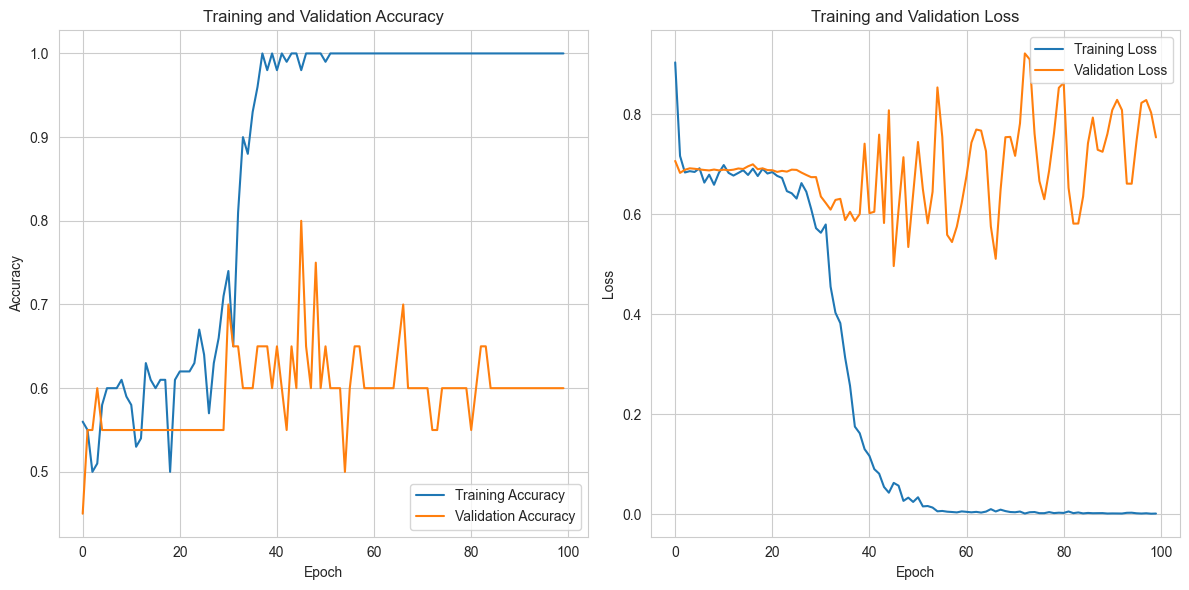

In [87]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()
